# Bitcoin Recurrent Neural Network
- Abstract
- Long short-term memory(LSTM)
- Batch Norm

## 1. Settings
### 1) Import required libraries

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from visdom import Visdom
viz = Visdom()

In [2]:
import unidecode
import string
import random
import re
import time, math
from utils2 import *
import matplotlib.pyplot as plt

## 2) Hyperparameter

In [33]:
num_epochs = 5000
hidden_size = 100
output_size=1
batch_size =1
num_layers = 3
lr = 0.002
NUM_STEPS = 500
chunk_len=200
path = './data/bitstamp.csv'

In [34]:
# train Parameters
seq_length = 200
sub_seq_length = 150
data_dim = 18
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 101
plot_name = 'LSTM_new_01'

## 2. Data

### 2) Get data

In [35]:
data = data_loading(path)

In [36]:
len(data)

2171

### 3) Chunk into input & label

In [37]:
def random_chunk():
    start_index = random.randint(0, len(data) - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

print(random_chunk().shape)

(201, 18)


In [38]:
def random_training_set():    
    chunk = random_chunk()
    inp = torch.from_numpy(chunk[:-1])
    target = torch.from_numpy(chunk[1:,-1])
    return Variable(inp).cuda(), Variable(target).cuda()

## 3. Model & Optimizer
### 1) Model

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.encoder = nn.Linear(input_size, hidden_size)
        self.BN = nn.BatchNorm1d(hidden_size)
        self.rnn = nn.LSTM(hidden_size,hidden_size,num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden,cell):
        out = self.encoder(input.view(1,-1))
        out = self.BN(out.view(1,-1))
        #out = self.encoder(input)
        out,(hidden,cell) = self.rnn(out.view(1,1,-1),(hidden,cell))
        out = self.decoder(out.view(batch_size,-1))
        return out,hidden,cell
    def init_hidden(self):
        hidden = Variable(torch.zeros(num_layers,batch_size,hidden_size)).cuda()
        cell = Variable(torch.zeros(num_layers,batch_size,hidden_size)).cuda()
        return hidden,cell
model = RNN(data.shape[1], hidden_size, output_size, num_layers).cuda()

### 2) Loss & Optimizer

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()

### 3) Training

In [41]:
for i in range(num_epochs):
    inp , label = random_training_set()
    hidden,cell = model.init_hidden()
    loss = 0
    optimizer.zero_grad()
    for j in range(chunk_len-1):
        x  = inp[j]
        y_ = label[j]
        y,hidden,cell = model(x,hidden,cell)
        loss += loss_func(y,y_)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i)
        print("\n",loss/chunk_len,"\n")

0

 Variable containing:
 29.5031
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

100

 Variable containing:
 1.5063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

200

 Variable containing:
1.00000e-02 *
  6.4468
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

300

 Variable containing:
 1.4343
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

400

 Variable containing:
 0.1095
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

500

 Variable containing:
 0.1103
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

600

 Variable containing:
 0.4465
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

700

 Variable containing:
 0.4742
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

800

 Variable containing:
 2.5764
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

900

 Variable containing:
 0.6082
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

1000

 Variable containing:
 4.2590
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

1100

 Variable containing:
 0.8346
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

1200

 Varia

### 4. Inference

In [28]:
def inference_set():    
    inp = torch.from_numpy(data[:-1])
    target = torch.from_numpy(data[1:,-1])
    return Variable(inp).cuda(), Variable(target).cuda()

In [29]:
aa = data[:-1]
aa.shape

(2170, 18)

In [30]:
def inference():
    inp , label = inference_set()
    hidden,cell = model.init_hidden()
    optimizer.zero_grad()
    real=[]
    predict=[]
    for j in range(len(inp)-1):
        x  = inp[j]
        y_ = label[j]
        y,hidden,cell = model(x,hidden,cell)
        #print(y_.cpu().data.numpy()[0])
        real.append(y_.cpu().data.numpy()[0])
        #print(y.cpu().data.numpy()[0][0])
        predict.append(y.cpu().data.numpy()[0][0])
        #predict.np.append(y.cpu())
    return real , predict

In [31]:
real, predict = inference()

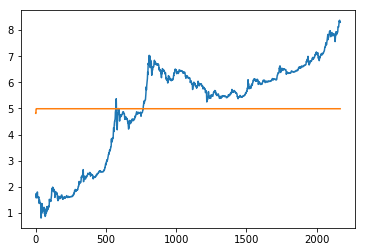

In [32]:
plt.figure
plt.plot(real)
plt.plot(predict)
plt.show()